In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

#df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = pd.concat([dff[['text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_sentence'])
df = df[df['y_sentence'] < 481]

In [4]:
X = df.drop('y_sentence', axis=1)
y = df['y_sentence']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

#X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
#X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (529,))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (662,))
#input_4 = tf.keras.Input(dtype = tf.float32, shape = (6,))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_4)


#dense_layer_4_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_4)
#dense_layer_4_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_1)
#dense_layer_4_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_2)
#dense_layer_4_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_3)
#dropout_4_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_4_4)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

23324


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
#concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])


dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_3)

#model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)
model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [12]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.2), metrics=['mse', 'mae'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     2985472     input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 529)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 662)]        0                                            
______________________________________________________________________________________________

In [13]:
#history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1)
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1)

Train on 3193 samples, validate on 355 samples
Epoch 1/100
3193/3193 [==============================] - 4s 1ms/sample - loss: 1825.7091 - mse: 1802.6147 - mae: 20.4448 - val_loss: 1368.0151 - val_mse: 1341.3082 - val_mae: 19.8964
Epoch 2/100
3193/3193 [==============================] - 1s 337us/sample - loss: 1607.8203 - mse: 1579.2961 - mae: 20.2616 - val_loss: 1291.1709 - val_mse: 1260.5299 - val_mae: 18.1216
Epoch 3/100
3193/3193 [==============================] - 1s 335us/sample - loss: 1468.3205 - mse: 1433.6975 - mae: 19.0332 - val_loss: 1211.3561 - val_mse: 1172.9504 - val_mae: 18.1076
Epoch 4/100
3193/3193 [==============================] - 1s 335us/sample - loss: 1380.2566 - mse: 1338.0172 - mae: 18.3811 - val_loss: 1162.6626 - val_mse: 1118.0000 - val_mae: 17.2267
Epoch 5/100
3193/3193 [==============================] - 1s 332us/sample - loss: 1285.8152 - mse: 1237.7646 - mae: 17.7234 - val_loss: 1123.5744 - val_mse: 1072.9990 - val_mae: 16.9633
Epoch 6/100
3193/3193 [=======

3193/3193 [==============================] - 1s 346us/sample - loss: 557.6447 - mse: 420.6653 - mae: 11.3083 - val_loss: 895.4450 - val_mse: 757.2836 - val_mae: 14.4463
Epoch 46/100
3193/3193 [==============================] - 1s 346us/sample - loss: 557.0213 - mse: 418.4196 - mae: 11.5412 - val_loss: 902.7942 - val_mse: 763.6082 - val_mae: 14.1377
Epoch 47/100
3193/3193 [==============================] - 1s 346us/sample - loss: 561.8450 - mse: 422.5021 - mae: 11.3378 - val_loss: 903.5177 - val_mse: 763.2132 - val_mae: 14.2787
Epoch 48/100
3193/3193 [==============================] - 1s 346us/sample - loss: 542.4592 - mse: 401.7039 - mae: 11.2727 - val_loss: 900.8594 - val_mse: 759.7279 - val_mae: 14.2029
Epoch 49/100
3193/3193 [==============================] - 1s 347us/sample - loss: 532.0957 - mse: 390.9575 - mae: 10.9236 - val_loss: 891.0438 - val_mse: 749.2731 - val_mae: 14.1713
Epoch 50/100
3193/3193 [==============================] - 1s 345us/sample - loss: 512.1735 - mse: 369.5

3193/3193 [==============================] - 1s 349us/sample - loss: 285.8468 - mse: 158.3571 - mae: 7.9554 - val_loss: 836.2376 - val_mse: 708.8719 - val_mae: 13.9125
Epoch 91/100
3193/3193 [==============================] - 1s 353us/sample - loss: 299.5613 - mse: 172.8436 - mae: 8.1110 - val_loss: 842.9787 - val_mse: 716.2808 - val_mae: 13.9761
Epoch 92/100
3193/3193 [==============================] - 1s 353us/sample - loss: 281.4638 - mse: 155.3762 - mae: 7.9409 - val_loss: 840.3798 - val_mse: 714.6173 - val_mae: 13.9613
Epoch 93/100
3193/3193 [==============================] - 1s 350us/sample - loss: 277.8468 - mse: 152.4539 - mae: 7.9467 - val_loss: 855.3494 - val_mse: 730.8965 - val_mae: 13.7511
Epoch 94/100
3193/3193 [==============================] - 1s 349us/sample - loss: 269.8674 - mse: 145.8093 - mae: 7.7053 - val_loss: 820.1058 - val_mse: 696.5592 - val_mae: 14.0478
Epoch 95/100
3193/3193 [==============================] - 1s 347us/sample - loss: 271.0908 - mse: 147.8031 -

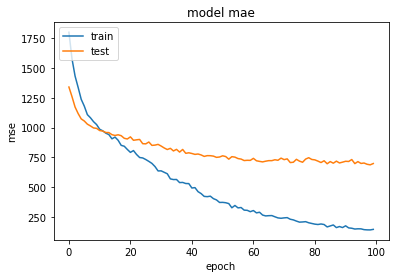

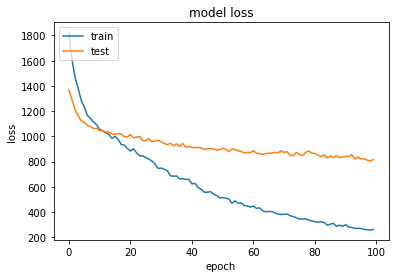

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
#score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
print("Test MAE: ", score[2])

395/395 [==============================] - 0s 280us/sample - loss: 453.4813 - mse: 335.1682 - mae: 11.4217
[453.4813395439824, 335.16824, 11.421728]
Test Score: 453.4813395439824
Test MSE: 335.16824
Test MAE:  11.421728


In [16]:
#tf-idf 0.2
#10-10-10-10 배치 16, 에폭 100, Adamax 0.001: 393 392 <===
#50-10-10-10 배치 16, 에폭 100, Adamax 0.001: 528
#100-100-100-100 배치 16, 에폭 100, Adamax 0.001: 813
#8-8-8-8 배치 16, 에폭 100, Adamax 0.001: 407
#12-12-12-12 배치 16, 에폭 100, Adamax 0.001: 616

#10-10-10-10 배치 2, 에폭 100, Adamax 0.001: 594
#10-10-10-10 배치 32, 에폭 100, Adamax 0.001:358 364 <== 에폭 50: 360 358 
#10-10-10-10 배치 64, 에폭 100, Adamax 0.001: 374
#10-10-10-10 배치 128, 에폭 100, Adamax 0.001: 369

#10-10-10-10 배치 32, 에폭 100, Adamax 0.0001: 505// 에폭 200: 425// 에폭 300: 387// 에폭 400: 371// 에폭 500:371 // 에폭 600: 367
#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005: 362 363기울기가 더 그럴 듯 하다. // 에폭 200 : 359 
#10-10-10-10 배치 32, 에폭 100, Adamax 0.005: 435
#10-10-10-10 배치 32, 에폭 100, Adamax 0.01: 586


#10-10-10-10 배치 32, 에폭 100, Adam 0.001: 461 그래프 못 생김

#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이: 346 344 343 //애폭 120: 341 370//에폭150: 347 365 361 //에폭 400: 414
#10-10-10-10 배치 32, 에폭 100, Adamax 0.001, 판사 없이: 350 // 에폭400: 534
#10-10-10-10 배치 32, 에폭 100, RMSProp 0.001, 판사 없이: 621
#10-10-10-10 배치 32, 에폭 100, RMSProp 0.0005, 판사 없이: 664
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.001, 판사 없이: 779 //에폭200: 703
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.01, 판사 없이:580 
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.1, 판사 없이: 408
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.15, 판사 없이: 368
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.2, 판사 없이: 329 334 334 334 <==================에폭 120: 363// 에폭 80: 351
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.25, 판사 없이: 405
#10-10-10-10 배치 32, 에폭 100, Adadelta 0.3, 판사 없이: 360 360 365 

#10-10-10-10 배치 32, 에폭 100, Adagrad 0.001, 판사 없이: 498
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.005, 판사 없이: 412
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.01, 판사 없이: 394
#10-10-10-10 배치 32, 에폭 100, Adagrad 0.05, 판사 없이: 404

#10-10-10-10 배치 32, 에폭 100, Nadam 0.005, 판사 없이: 494
#10-10-10-10 배치 32, 에폭 100, Nadam 0.001, 판사 없이: 504
#10-10-10-10 배치 32, 에폭 100, Nadam 0.0005, 판사 없이: 388
#10-10-10-10 배치 32, 에폭 100, Nadam 0.0001, 판사 없이: 406



#tf-idf 0.1
#10-10-10-10 배치 32, 에폭 100, Adamax 0.0005, 판사 없이: 687


